In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import scipy.stats as ss
import collections
import corner
import seaborn as sns
import random
pd.options.mode.chained_assignment = None
%matplotlib inline

In [3]:
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.
    Richard M. Brugger, "A Note on Unbiased Estimation of the Standard Deviation", The American Statistician (23) 4 p. 32 (1969)

    values, weights -- Numpy ndarrays with the same shape.
    """
    n=len(values)
    average = np.average(values, weights=weights)
    variance = (n/(n-1.5))*np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return np.sqrt(variance),average

In [4]:
df=pd.read_csv("NED27.02.1-D-14.1.0-20170227.csv",skiprows=12)
df=df[np.isnan(df['redshift (z)'])] # only measurements without redshift data are useful here

In [5]:
df=pd.read_csv("NED27.09.1-D-14.2.0-20170929.csv",skiprows=12)
df=df[np.isnan(df['redshift (z)'])] # only measurements without redshift data are useful here

In [6]:
def selectdata_lite(mymethod,df):
    dfa=df[~np.isfinite(df.err)] # database of non reported errors
    df1=df[np.isfinite(df.err)] # remove measurements that do not report an error
    df1=df1[df1.err!=0] # remove measurements that report an error as zero ¬¬
# Select a method for analysis
    df1=df1[df1.Method==mymethod] # choose a method
    namelist=list(df1['Galaxy ID']) # list of galaxies
    counter=collections.Counter(namelist) # count measurements per galaxy
# Select galaxies with a minimum number of measurements
    ulist=[]
    ulist2=[]
    nmeas=1
    for i in counter.keys():
        if counter[i]>nmeas:
            ulist+=[i] # all galaxies with more than n_meas measurements
        if counter[i]>=1:
            ulist2+=[i] # all galaxies with at least one measurement w/a reported error
    print('No. of Galaxies with reported errors is %i' % len(ulist2) )
    print('No. of Galaxies with more than %i measurements is %i' % (nmeas,len(ulist)) )
# Create database for bootstrap, remove unnecessary columns
    dfs=df1[np.in1d(df1['Galaxy ID'],ulist)] # dataframe with galaxies with more than nmeas measurements
    colu=list(df.columns)
    for i in ['Galaxy ID', 'm-M', 'err', 'D (Mpc)']:
        colu.remove(i)
    dfs.drop(colu, inplace=True, axis=1)
# Create database for non-reported errors
    df1a=dfa[dfa.Method==mymethod] # all measurements without reported errors
    elist=list(np.unique(df1a['Galaxy ID'])) # list of galaxies with measurements without reported errors
    dmeana=[]
    for i in elist:
        dfilter=np.in1d(df1a['Galaxy ID'],i)
        dummy=df1a[dfilter]
        dmeana+=[dummy['D (Mpc)'].mean()] # average reported distance (D), no need for weighted... there are no weights
    filtr=~np.in1d(elist,ulist2)
    nulista=np.asarray(elist)[filtr] # list of galaxies without reported errors
    dista=np.asarray(dmeana)[filtr] # mean distance of galaxies without reported errors
    print('No. of Galaxies without reported errors is %i' % len(nulista) )
    return ulist,dfs,nulista,dista,len(nulista),len(ulist),len(ulist2)

In [7]:
mymethod='Tully-Fisher'
ulist,dfs,nulista,dista,*mma=selectdata_lite(mymethod,df)

No. of Galaxies with reported errors is 11376
No. of Galaxies with more than 1 measurements is 9100
No. of Galaxies without reported errors is 818


In [25]:
%%time
np.random.seed(10)
nbins=100000 # 1e4 -> 4 minutes
em=[] # number of measurements per galaxy
bootp50=[] # mean error from the bootstrap for each galaxy
bootsig=[] # uncertainty of the error -> may not be a good predictor
dboot=[] # mean bootstrap distance
bootmad=[] # median absolute deviation (robust)
wsnt=[] # error propagated from the weighted standard deviation of the distance modulus (natural way to do it)
dwa=[] # distance using weighted average of modulus and err (for show mostly)
ecf=[]
eqd=[]
for i in ulist:
    dfilter=np.in1d(dfs['Galaxy ID'],i)
    dummy=dfs[dfilter]
    em+=[len(dummy)] # n_meas, number of measurements per galaxy
    tli=[]
    for km,ke in zip(dummy['m-M'],dummy['err']):
        tli+=[list(10**(np.random.normal(km,ke,nbins)/5.+1))] # bootstrap draw for each gal
    booterr=np.percentile(tli, 84,axis=0)-np.percentile(tli, 16,axis=0) # sigma draws from bootstrap for each gal
    bootmean=np.median(tli,axis=0) # mean draws from bootstrap for each gal
    bootp50+=[np.mean(booterr)/1e6] # mean bootstrap error
    bootsig+=[((np.percentile(booterr, 84)-np.percentile(booterr, 16)))/2e6] # the error of the error
    bootmad+=[np.median(np.abs(tli - np.median(tli)))]
    dboot+=[np.median(bootmean)/1e6] # bootstrap mean D
    wnat,avnat = weighted_std(dummy['m-M'],1/dummy['err']**2)
    distwav=10**(avnat/5+1)/1e6
    dwa+=[distwav] #
    wsti=0.461*distwav*wnat # weighted standard deviation
    wsnt+=[wsti] 
    ecfi=0.461*distwav/np.sqrt((1/dummy['err']**2).sum()) # error according to cosmicflows
    ecf+=[ecfi]
    eqd+=[np.sqrt(ecfi**2+wsti**2)]    
# weighted std using D and propagated err is similar to propagated D error using weighted std on modulus and error

CPU times: user 40min 12s, sys: 824 ms, total: 40min 13s
Wall time: 40min 16s


In [23]:
#mulist=[i.replace(" ", "") for i in ulist]
#np.savetxt('calculated.txt',np.array(mulist),fmt='%s')

In [126]:
d = {'names': ulist, 'meas': em, 'bootp50':bootp50, 'bootsig':bootsig,'dboot':dboot,'wsnt':wsnt,'dwa':dwa,'ecf':ecf,'eqd':eqd,'bootmad':bootmad}
df = pd.DataFrame(data=d)
df.to_csv("bootstrap_results.csv")

In [127]:
ndf=pd.read_csv("bootstrap_results.csv")
em=df.meas
dboot=ndf.dboot
dwa=ndf.dwa
bootp50=ndf.bootp50
wsnt=ndf.wsnt
ecf=ndf.ecf
eqd=ndf.eqd
bootmad=ndf.bootmad
bootsig=ndf.bootsig

In [165]:
ndf[ndf.bootp50>100]

,Unnamed: 0,bootmad,bootp50,bootsig,dboot,dwa,ecf,eqd,meas,names,wsnt
483,483,5.375386e+07,116.755829,62.591359,431.147629,435.195985,36.342909,38.281225,3,2MASX J01034126-0220153,12.026852
1406,1406,9.693265e+07,162.027770,57.437141,255.449634,208.826072,29.324999,205.468475,2,ARK 090,203.365038
1418,1418,5.502399e+06,2412.743438,62.758824,7.969831,7.892862,0.612524,4.808603,5,NGC 1058,4.769432
1446,1446,4.646963e+07,101.774312,53.313548,347.688360,353.921138,29.894263,35.036997,3,2MASX J02470016-0009215,18.273592
2698,2698,5.441721e+07,102.058727,53.387565,273.356174,269.162519,37.870096,72.054461,3,2MFGC 05660,61.300092
3398,3398,4.979769e+07,111.146144,58.545916,360.757432,367.374843,31.278339,36.763140,3,2MASX J09222262-0029198,19.318230
5392,5392,4.893437e+07,100.135558,53.764674,448.633930,450.597987,36.070372,36.522445,3,2MASX J12531100-2911079,5.728632
5814,5814,4.703139e+07,102.451846,51.705182,321.318259,330.790788,27.908795,42.871600,3,2MFGC 10840,32.543405
5986,5986,4.355615e+07,150.781078,41.090578,109.873262,125.512369,14.308078,103.071096,3,NGC 5296,102.073159
6414,6414,7.214360e+07,223.479110,61.127714,250.546675,217.240284,15.687409,105.799420,4,CGCG 104-039,104.629931


In [164]:
ndf.dboot[ndf.bootp50>100]

483     431.147629
1406    255.449634
1418      7.969831
1446    347.688360
2698    273.356174
3398    360.757432
5392    448.633930
5814    321.318259
5986    109.873262
6414    250.546675
7297    334.127040
7333    512.490590
8791    442.401885
9050    604.352610
Name: dboot, dtype: float64

In [181]:
filt=np.array(em)>5
x=np.array(dboot)[filt]
xa=np.array(dwa)[filt]
y=np.array(bootp50)[filt]/2
w=np.array(wsnt)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]/1e6
ee=np.array(bootsig)[filt]

In [115]:
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)

In [146]:
sns.set(font='Arial')
reso=300

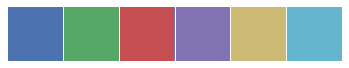

In [123]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

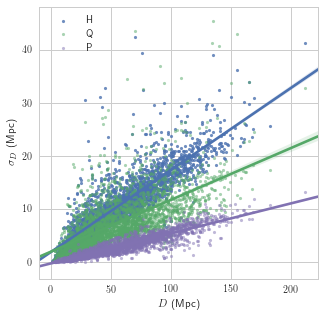

In [167]:
plt.figure(figsize=(5,5))
sns.set_style("whitegrid")
sns.regplot(x,y,label='H', scatter_kws={'s':10})
sns.regplot(x,qd, scatter_kws={'alpha':0.5,'s':10},label='Q') # green, quadrature
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.5,'s':10},label='P') # red, cosmicflows
#sns.regplot(x,z, scatter_kws={'alpha':0.3}) # purple, mad
plt.legend(loc='upper left')#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.savefig('mnras/hqp.pdf', dpi=reso,transparent=True)

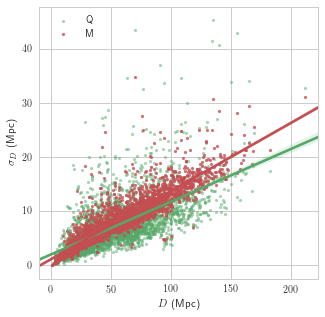

In [168]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1],label='Q', scatter_kws={'alpha':0.5,'s':10})
sns.regplot(x,z,color=current_palette[2],label='M', scatter_kws={'alpha':0.8,'s':10})

plt.legend(loc='upper left')#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.savefig('mnras/qm.pdf', dpi=reso,transparent=True)

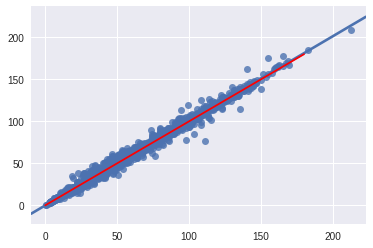

In [13]:
sns.regplot(x,xa)
plt.plot([0,180],[0,180],c='r')

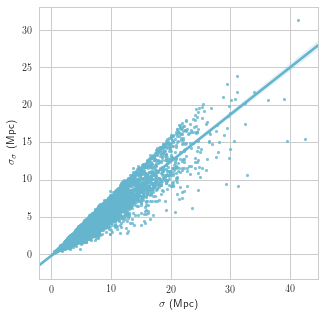

In [188]:
plt.figure(figsize=(5,5))

sns.regplot(y,ee,color=current_palette[5], scatter_kws={'s':10}) # error of the error
plt.xlabel(r"$\sigma$ (Mpc)")
plt.ylabel(r'$\sigma_\sigma$ (Mpc)')
plt.savefig('mnras/ee.pdf', dpi=reso,transparent=True)

(array([ 110.,  470.,  489.,  450.,  337.,  369.,  346.,  251.,  178.,
         128.,  103.,   67.,   39.,   25.,    8.,   10.,    0.,    1.,
           0.,    1.]),
 array([   0.76083513,   11.34116295,   21.92149077,   32.50181858,
          43.0821464 ,   53.66247421,   64.24280203,   74.82312984,
          85.40345766,   95.98378548,  106.56411329,  117.14444111,
         127.72476892,  138.30509674,  148.88542455,  159.46575237,
         170.04608019,  180.626408  ,  191.20673582,  201.78706363,
         212.36739145]),
 <a list of 20 Patch objects>)

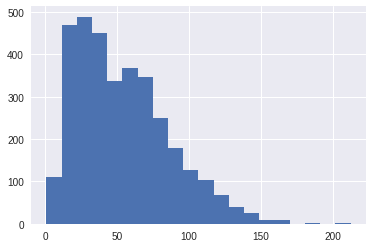

In [24]:
plt.hist(x,bins=20)

# Working Models

## Linear Model

Works for n_meas > 14 (468 galaxies), but discrepancy plot shows different distributions for simulated and observed discrepancies. $\sigma_B$ is the bootstrap-obtained (real) error, $\sigma_{SW}$ is the sigma used for statistical weight in likelihood.

$$\sigma_B=mD+b $$
$$\sigma_{SW}=f\sigma_B$$

We don't like it because it is not super-physical. Also, it's better not to use $\sigma_\sigma$, as we do not have it for empty measurements. We should also look at empty measurements for galaxies that have other measurements.

In [175]:
y=z

In [211]:
def lnlike2(theta, x, y):# modelo que usa una fracción de sigma como peso estadistico
    m ,b, f = theta
    model = m * x + b    
    inv_sigma2 = 1.0/((f*model)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior2(theta):
    m, b, f = theta
    if -10 < m < 10 and -50 < b < 50 and 0 < f < 1.1:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob2(theta, x, y):
    lp = lnprior2(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike2(theta, x, y)

def discrep2(ii,samples,x,y):
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//100
    for i in range(ndisc):
        yexp=samples[i,0]*x+samples[i,1]
        modpar=samples[np.random.randint(len(samples))]
        ysim=np.random.normal(modpar[0]*x+modpar[1],(modpar[0]*x+modpar[1])*modpar[2])
        if np.any(ysim<0)|np.any(ysim<0):
            rej+=1
        else:        
#            yexp=np.sqrt(yexp)
#            ysim=np.sqrt(ysim)
#            y=np.sqrt(y)
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()]
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()]
    print("Rejection rate =",100*rej//ndisc,"%") # rejection rate
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
#        plt.figure(figsize=(6,6))
        plt.scatter(disco,discs,alpha=0.6,label=r"$N>$"+str(ii)+", Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
        dmax=np.max(np.hstack((disco,discs)))
        dmin=np.min(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax,2)
        plt.plot(ppp,ppp,c='r')
#        plt.xlim(dmin,dmax)
#        plt.ylim(dmin,dmax)
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))
#        return ppp,discs,disco

In [ ]:
plt.figure(figsize=(6,6))
for i in range(12,16):
    filt=np.array(em)>i
    print(filt.sum())
    x=np.array(dboot)[filt]
    y=np.array(bootp50)[filt]

    nll = lambda *args: -lnlike2(*args)## AQUI
    result = op.minimize(nll, [1.]*3, args=(x, y)) ## AQUI
    m_ml, b_ml,f_ml = result["x"]## AQUI
    print(i,m_ml,b_ml,f_ml)## AQUI
    #    if b_ml > 0:
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=(x, y)) ## AQUI
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    sampler.run_mcmc(pos, 1000);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    sth=samples.mean(axis=0)
    #fig = corner.corner(samples, labels=["$m$", "$b$","$f$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
    print(i,sth)
    discrep2(i,samples,x,y)
plt.legend(loc='lower right')
plt.xlabel('Observed discrepancies')
plt.ylabel('Simulated discrepancies')
plt.xlim(75,250)
plt.ylim(75,250)

921
12 0.368282071037 2.31074993084 0.243992933239


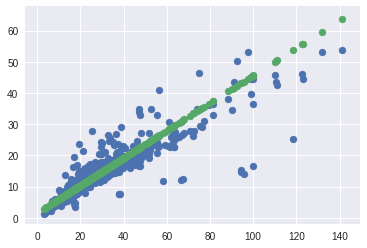

In [173]:
plt.scatter(x,y)
plt.scatter(x,sth[0]*x+sth[1])

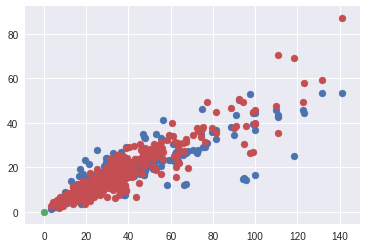

In [174]:
modpar=samples[np.random.randint(len(samples))]
ysim=np.random.normal(modpar[0]*x+modpar[1],modpar[2]*(modpar[0]*x+modpar[1]))
plt.scatter(x,y)
plt.scatter([0],[0])
plt.scatter(x,ysim)

## Quadratic model

Works for n_meas > 22 (53 galaxies, 1219 measurements).

$$\sigma_B=mD^2+b^2 $$
$$\sigma_{SW}=f\sigma_B$$

We prefer the linear model because it uses more data. Discrepancy plot looks better, though.

In [82]:
def lnlike3(theta, x, y):# modelo que usa una fracción de sigma_sigma
    m ,b, f = theta
    model = m * x**2+ b**2
    inv_sigma2 = 1.0/((f*model)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior3(theta):
    m, b, f = theta
    if 0 < m < 10 and 0 < b < 10 and 0 < f < 1:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob3(theta, x, y):
    lp = lnprior3(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike3(theta, x, y)

def discrep3(samples,x,y):
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//100
    for i in range(ndisc):
        yexp=samples[i,0]*x**2+samples[i,1]**2
        modpar=samples[np.random.randint(len(samples))]
        ymod=modpar[0]*x**2+modpar[1]**2
        ysim=np.random.normal(ymod,modpar[2]*ymod)
        if np.any(ysim<0)|np.any(ysim<0):
            rej+=1
        else:        
#            yexp=np.sqrt(yexp)
#            ysim=np.sqrt(ysim)
#            y=np.sqrt(y)
#            discs+=[((ysim-yexp)**2).sum()]
#            disco+=[((y-yexp)**2).sum()]
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()]
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()]
    print("Rejection rate =",100*rej//ndisc,"%") # rejection rate
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
        plt.figure(figsize=(6,6))
        plt.scatter(discs,disco)
        dmax=np.max(np.hstack((disco,discs)))
        dmin=np.min(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax,2)
        plt.plot(ppp,ppp,c='r')
        plt.xlim(dmin,dmax)
        plt.ylim(dmin,dmax)
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

921
12 0.00477309317689 2.90394456452 0.290378648083
12 [ 0.00477904  2.90234524  0.29119447]
Rejection rate = 22 %
Bayesian p-value: 0.574712643678


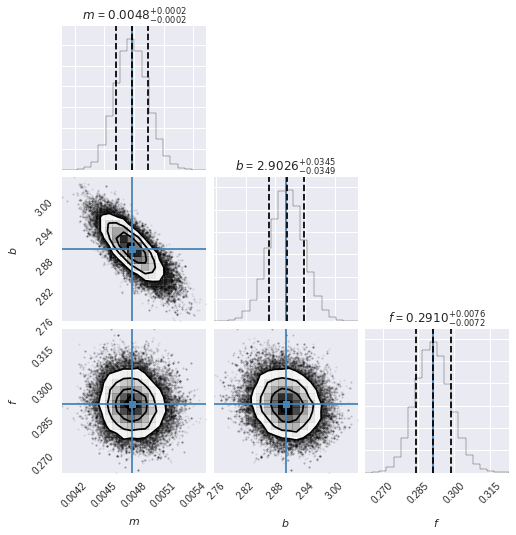

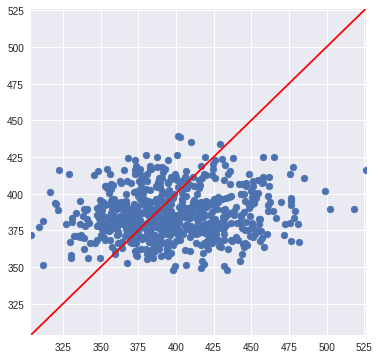

In [83]:
i=12 # 12 seems to be the magic number
filt=np.array(em)>i
print(filt.sum())
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
nll = lambda *args: -lnlike3(*args)## AQUI
result = op.minimize(nll, [1.]*3, args=(x, y)) ## AQUI
m_ml, b_ml,f_ml = result["x"]## AQUI
print(i,m_ml,b_ml,f_ml)## AQUI
#    if b_ml > 0:
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob3, args=(x, y)) ## AQUI
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
sth=samples.mean(axis=0)
fig = corner.corner(samples, labels=["$m$", "$b$","$f$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
print(i,sth)
discrep3(samples,x,y)

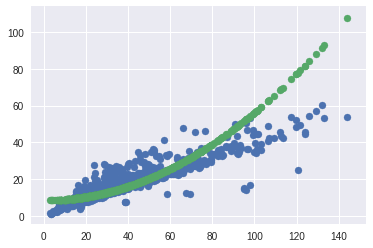

In [84]:
plt.scatter(x,y)
plt.scatter(x,sth[0]*x**2+sth[1]**2)

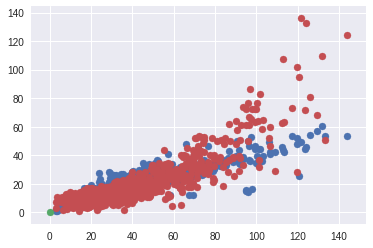

In [85]:
modpar=samples[np.random.randint(len(samples))]
ysim=np.random.normal(modpar[0]*x**2+modpar[1]**2,modpar[2]*(modpar[0]*x**2+modpar[1]**2))
plt.scatter(x,y)
plt.scatter([0],[0])
plt.scatter(x,ysim)

## Quadrature model

Works for n_meas > 22 (53 galaxies, 1219 measurements). Bad rejection rate, not great discrepancy plot. Very physical, though. 

$$\sigma_B^2=mD^2+b^2 $$
$$\sigma_{SW}=f\sigma_B$$

Can make decent predictions for D < 60 Mpc. Can also predict a value for the systematic error.

In [118]:

def discrep4(samples,x,y):
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//100
    for i in range(ndisc):
        yexp=samples[i,0]*x**2+samples[i,1]**2
        modpar=samples[np.random.randint(len(samples))]
        ymod=modpar[0]*x**2+modpar[1]**2
        ysim=np.random.normal(ymod,modpar[2]*ymod)
        if np.any(ysim<0)|np.any(ysim<0):
            rej+=1
        else:        
#            yexp=np.sqrt(yexp)
#            ysim=np.sqrt(ysim)
#            y=np.sqrt(y)
#            discs+=[((ysim-yexp)**2).sum()]
#            disco+=[((y-yexp)**2).sum()]
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()]
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()]
    print("Rejection rate =",100*rej//ndisc,"%") # rejection rate
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
        plt.figure(figsize=(6,6))
        plt.scatter(discs,disco)
        dmax=np.max(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax,2)
        plt.plot(ppp,ppp,c='r')
        plt.xlim(0,dmax)
        plt.ylim(0,dmax)
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

53
22 0.271938580565 1.43715365378 0.397612562257
22 [ 0.26360051  1.79472511  0.4151994 ]
Rejection rate = 34 %
Bayesian p-value: 0.56734006734


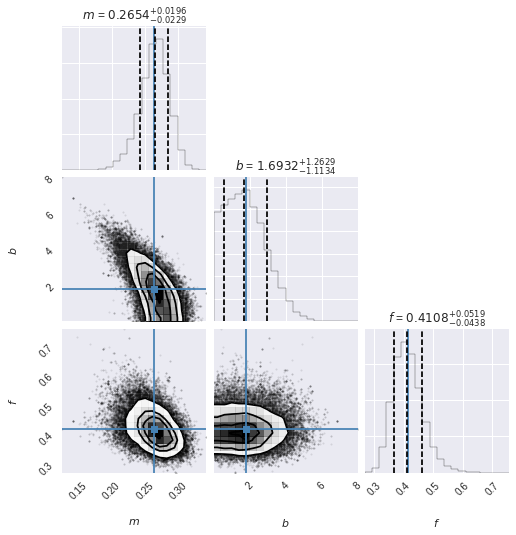

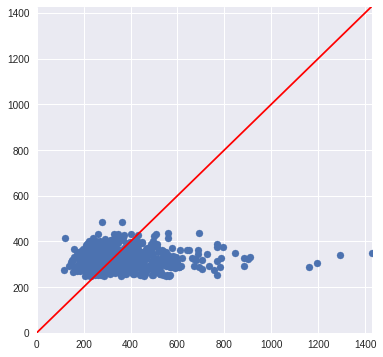

In [119]:
i=22
filt=np.array(em)>i
print(filt.sum())
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
y=y**2
nll = lambda *args: -lnlike3(*args)## AQUI
result = op.minimize(nll, [1.]*3, args=(x, y)) ## AQUI
m_ml, b_ml,f_ml = result["x"]## AQUI
print(i,m_ml,b_ml,f_ml)## AQUI
#    if b_ml > 0:
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob3, args=(x, y,yerr)) ## AQUI
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
sth=samples.mean(axis=0)
fig = corner.corner(samples, labels=["$m$", "$b$","$f$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
print(i,sth)
discrep4(samples,x,y)

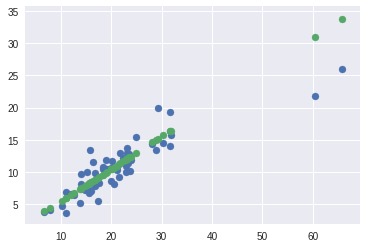

In [120]:
plt.scatter(x,np.sqrt(y))
plt.scatter(x,np.sqrt(sth[0]*x**2+sth[1]**2))

In [ ]:
# 1) hacer folding con este modelo (lineal con 22 o 23, no me acuerdo) 
# 2) aplicar AD a todos? o KS? 
# 3) autocorrelation time (look elsewhere in repo)

(0, 70)

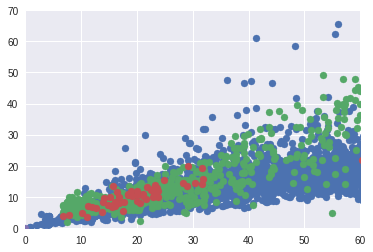

In [181]:
# funciona para el rango (modelo cuadratico)
# probar con los demás modelos
i=2
mxlim=60
filt=np.array(em)>i
xt=np.array(dboot)[filt]
yt=np.array(bootp50)[filt]
xli=dista # replace with dista
xli=xli[(xli<=60)&(xli>=x.min())]
# is this the best way to generate synthetic data? I don't remember, look at discrepancies
ysli=np.random.normal(modpar[0]*xli**2+modpar[1]**2,modpar[2]*(modpar[0]*xli**2+modpar[1]**2))
plt.scatter(xt,yt) # azules, todos los datos con nmeas >2
plt.scatter(xli,ysli) # verdes, datos sintéticos

#plt.scatter(x,y) # datos usados por el modelo
plt.scatter([0],[0])
plt.xlim(0,mxlim) 
plt.ylim(0,70)

In [147]:
((xli<=30)&(xli>=x.min())).sum()

337